# EDA và Trực quan hóa dữ liệu Amazon Sales

In [23]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from pywaffle import Waffle
from wordcloud import WordCloud
import squarify
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style ggplot cho matplotlib
plt.style.use('ggplot')
sns.set_palette("husl")

# Cấu hình hiển thị
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Thiết lập kích thước mặc định cho biểu đồ
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [24]:
# Tải dữ liệu đã làm sạch
df = pd.read_csv('Amazon_SaleData_Cleaned.csv')

# Chuyển đổi OrderDate sang datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Tạo các biến phụ trợ cho phân tích
df['Year'] = df['OrderDate'].dt.year
df['Month'] = df['OrderDate'].dt.month
df['Quarter'] = df['OrderDate'].dt.quarter
df['YearMonth'] = df['OrderDate'].dt.to_period('M')
df['DayOfWeek'] = df['OrderDate'].dt.day_name()
df['MonthName'] = df['OrderDate'].dt.month_name()

# Tính toán các metrics bổ sung
df['Revenue'] = df['TotalAmount']  # Doanh thu

print(f"Dataset shape: {df.shape}")
print(f"Thời gian: {df['OrderDate'].min()} đến {df['OrderDate'].max()}")
print(f"\nĐã tải dữ liệu và tạo các biến phụ trợ thành công!")

Dataset shape: (100000, 27)
Thời gian: 2020-01-01 00:00:00 đến 2024-12-29 00:00:00

Đã tải dữ liệu và tạo các biến phụ trợ thành công!


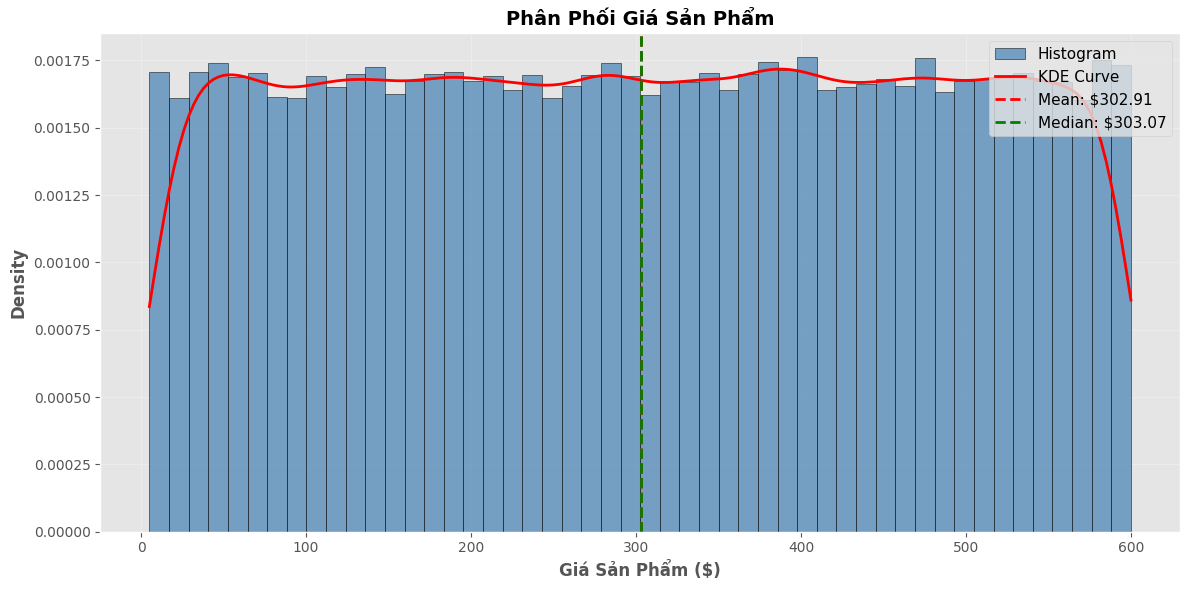

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
n, bins, patches = ax.hist(df['UnitPrice'], bins=50, density=True, alpha=0.7, 
                           color='steelblue', edgecolor='black', label='Histogram')

# Thêm KDE curve
data_clean = df['UnitPrice'].dropna()
if len(data_clean) > 1:
    kde = gaussian_kde(data_clean)
    x_range = np.linspace(data_clean.min(), data_clean.max(), 200)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE Curve')

# Thêm các đường thống kê
mean_val = df['UnitPrice'].mean()
median_val = df['UnitPrice'].median()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: ${mean_val:,.2f}')
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, 
           label=f'Median: ${median_val:,.2f}')

ax.set_title('Phân Phối Giá Sản Phẩm', fontweight='bold', fontsize=14)
ax.set_xlabel('Giá Sản Phẩm ($)', fontweight='bold', fontsize=12)
ax.set_ylabel('Density', fontweight='bold', fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Q2: Số lượng mua mỗi đơn được phân phối như thế nào?

Phân tích Quantity để xem hành vi mua lẻ hay mua số lượng lớn chiếm ưu thế.

**Nhận xét:**
- Phân phối số lượng mua cho thấy hành vi mua sắm của khách hàng. Nếu phân phối tập trung ở số lượng nhỏ (1-3), khách hàng có xu hướng mua lẻ.
- Nếu có nhiều đơn hàng với số lượng lớn (>5), điều này cho thấy có segment khách hàng mua số lượng lớn, có thể là doanh nghiệp hoặc mua để bán lại.
- Phân tích này giúp xác định chiến lược inventory và pricing phù hợp với từng nhóm khách hàng.

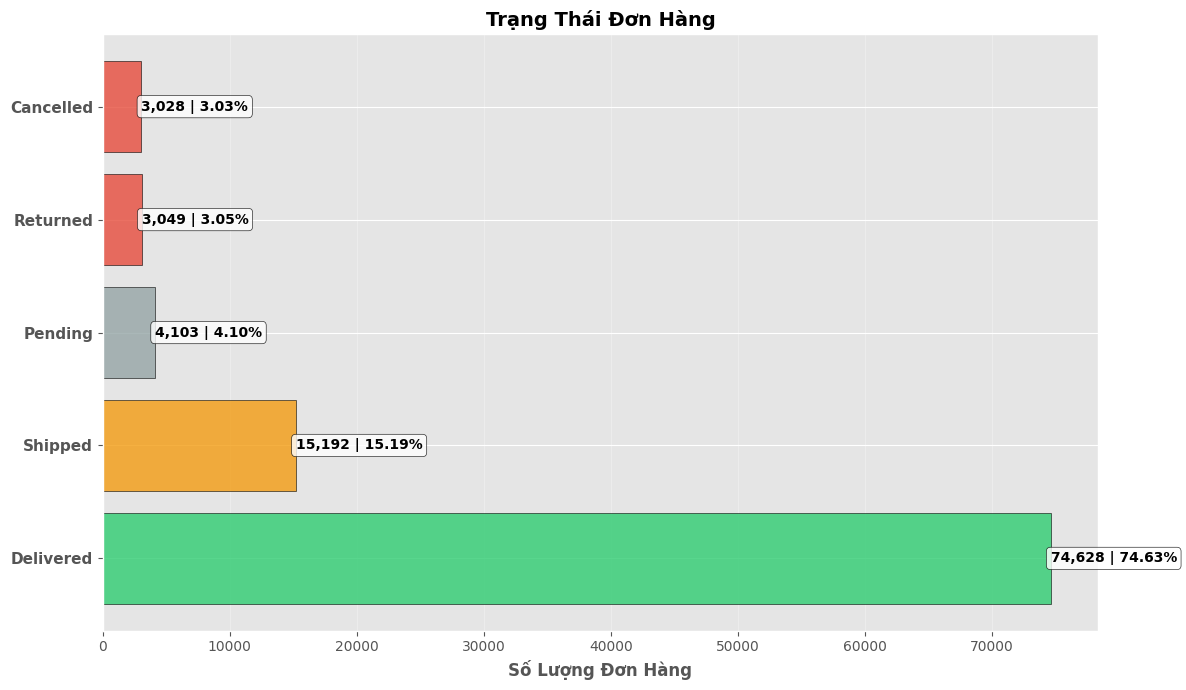

In [26]:
status_counts = df['OrderStatus'].value_counts()
total = status_counts.sum()
colors_status = ['#2ecc71' if s == 'Delivered' else '#f39c12' if s == 'Shipped' 
                else '#e74c3c' if s in ['Cancelled', 'Returned'] else '#95a5a6' 
                for s in status_counts.index]

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(status_counts)), status_counts.values, 
              color=colors_status, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(status_counts)))
ax.set_yticklabels(status_counts.index, fontweight='bold', fontsize=11)
ax.set_xlabel('Số Lượng Đơn Hàng', fontweight='bold', fontsize=12)
ax.set_title('Trạng Thái Đơn Hàng', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Thêm annotations với count và percentage
for i, (idx, count) in enumerate(status_counts.items()):
    percentage = (count / total) * 100
    value = f'{count:,} | {percentage:.2f}%'
    ax.text(count, i, value, ha='left', va='center', 
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.8),
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

### Q4: Phương thức thanh toán nào phổ biến nhất?

Phân tích mức độ phổ biến của các phương thức thanh toán khác nhau.

**Nhận xét:**
- Phương thức thanh toán phổ biến nhất chiếm tỷ lệ cao, cho thấy khách hàng có sự lựa chọn rõ ràng và tập trung vào một số phương thức ưa thích.
- Sự phân bố không đều giữa các phương thức thanh toán phản ánh thói quen và sở thích của khách hàng, cũng như mức độ tiện lợi của từng phương thức.
- Phân tích này giúp xác định phương thức thanh toán cần được ưu tiên phát triển và marketing để tăng trải nghiệm khách hàng.

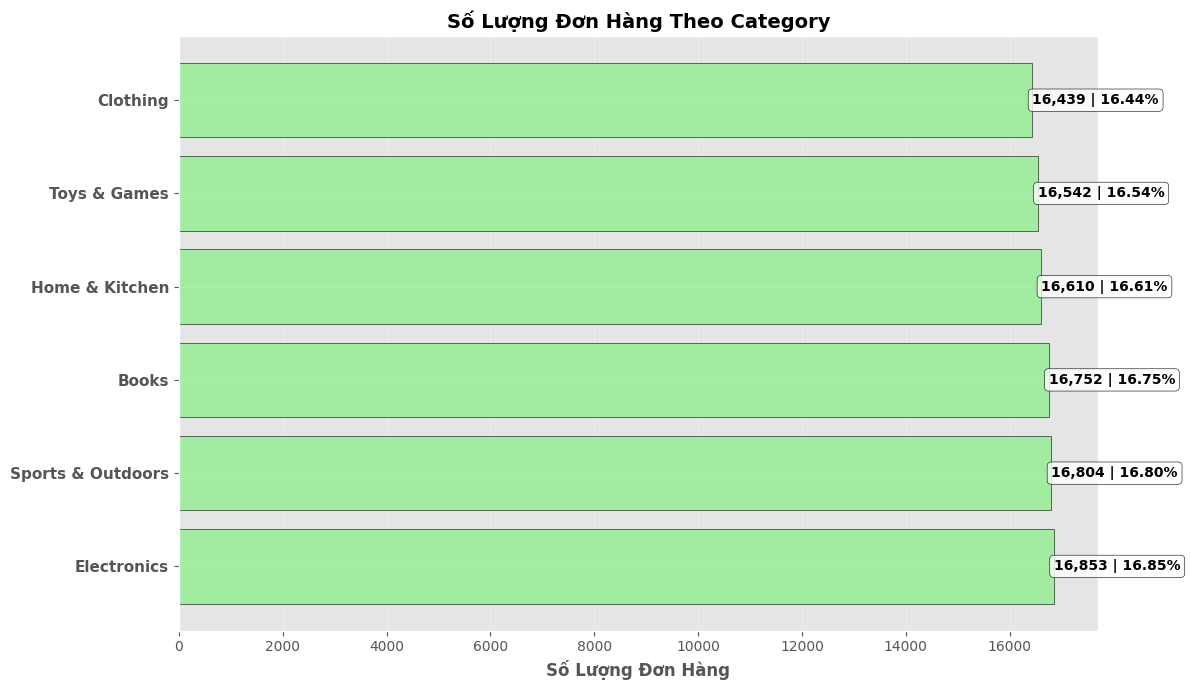

In [27]:
category_counts = df['Category'].value_counts().sort_values(ascending=False)
total = category_counts.sum()

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(range(len(category_counts)), category_counts.values, 
              color='lightgreen', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(category_counts)))
ax.set_yticklabels(category_counts.index, fontweight='bold', fontsize=11)
ax.set_xlabel('Số Lượng Đơn Hàng', fontweight='bold', fontsize=12)
ax.set_title('Số Lượng Đơn Hàng Theo Category', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')

# Thêm annotations với count và percentage
for i, (idx, count) in enumerate(category_counts.items()):
    percentage = (count / total) * 100
    value = f'{count:,} | {percentage:.2f}%'
    ax.text(count, i, value, ha='left', va='center', 
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', alpha=0.8),
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

### Q6: Danh mục nào tạo ra doanh thu cao nhất?

Phân tích doanh thu của từng danh mục để xác định category đóng góp nhiều nhất vào doanh thu.

**Nhận xét:**
- Category có doanh thu cao nhất là động lực chính của business, cần được ưu tiên trong chiến lược marketing và inventory.
- Sự chênh lệch doanh thu giữa các category phản ánh sự khác biệt về giá trị sản phẩm và nhu cầu thị trường.
- Category có doanh thu thấp có thể cần được đánh giá lại về pricing strategy hoặc có thể là niche market với tiềm năng phát triển.

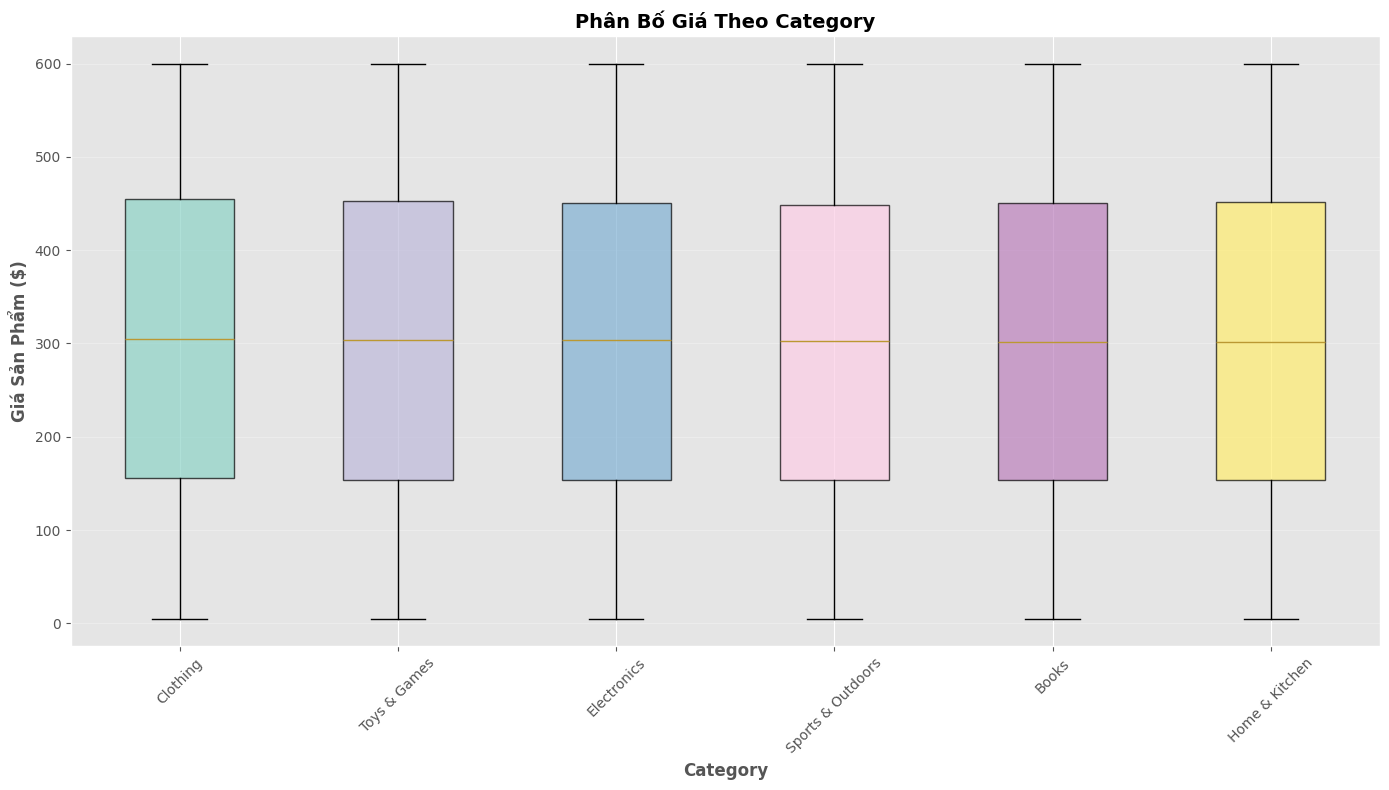

In [28]:
category_order = df.groupby('Category')['UnitPrice'].median().sort_values(ascending=False).index
df_sorted = df[df['Category'].isin(category_order)]
df_sorted['Category'] = pd.Categorical(df_sorted['Category'], categories=category_order, ordered=True)

fig, ax = plt.subplots(figsize=(14, 8))
bp = ax.boxplot([df_sorted[df_sorted['Category']==cat]['UnitPrice'].values for cat in category_order], 
                labels=category_order, patch_artist=True, vert=True)

colors_box = plt.cm.Set3(np.linspace(0, 1, len(category_order)))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('Phân Bố Giá Theo Category', fontsize=14, fontweight='bold')
ax.set_xlabel('Category', fontweight='bold', fontsize=12)
ax.set_ylabel('Giá Sản Phẩm ($)', fontweight='bold', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Q8: Top 10 thương hiệu nào dẫn đầu về doanh thu?

Xác định các thương hiệu dẫn đầu về doanh thu.

**Nhận xét:**
- Top 10 brand chiếm tỷ lệ doanh thu cao cho thấy sự tập trung của thị trường vào một số thương hiệu nổi bật.
- Brand dẫn đầu về doanh thu thường có brand recognition tốt, chất lượng sản phẩm được đánh giá cao, hoặc có chiến lược marketing hiệu quả.
- Phân tích này giúp xác định các brand cần được ưu tiên trong partnership và inventory management để tối ưu hóa doanh thu.

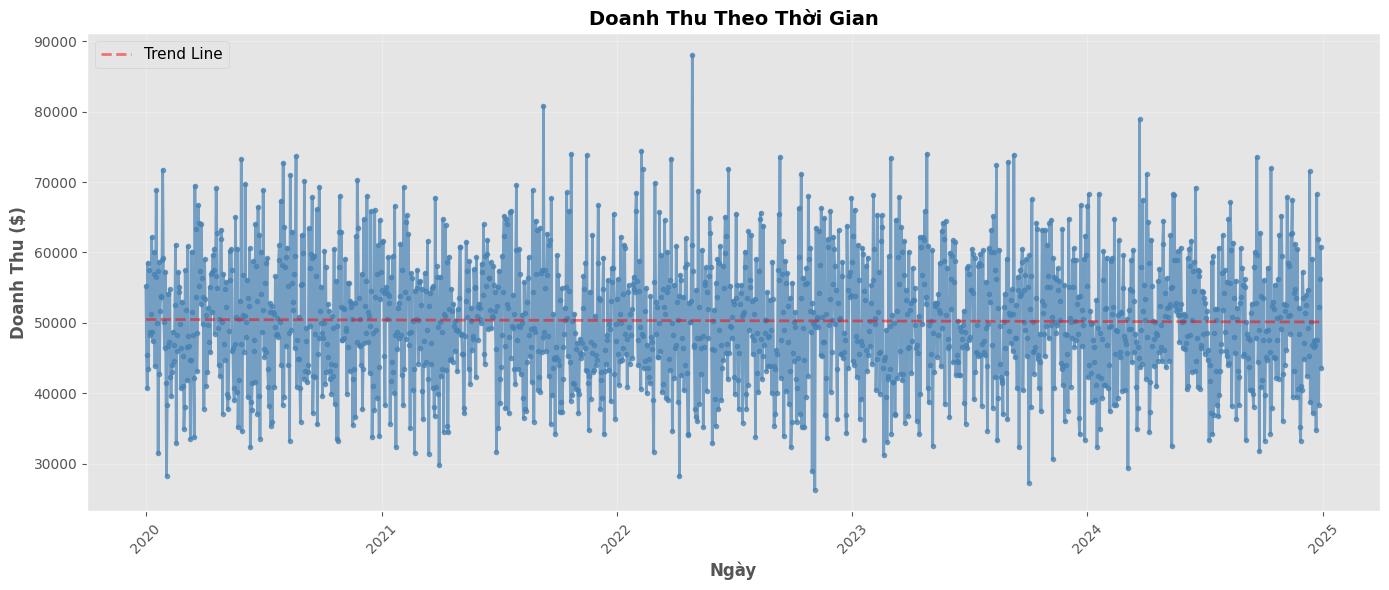

In [29]:
revenue_by_date = df.groupby('OrderDate')['Revenue'].sum().reset_index()
revenue_by_date = revenue_by_date.sort_values('OrderDate')

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(revenue_by_date['OrderDate'], revenue_by_date['Revenue'], 
        linewidth=2, color='steelblue', marker='o', markersize=3, alpha=0.7)

# Thêm trend line
z = np.polyfit(range(len(revenue_by_date)), revenue_by_date['Revenue'], 1)
p = np.poly1d(z)
ax.plot(revenue_by_date['OrderDate'], p(range(len(revenue_by_date))), 
        "r--", alpha=0.5, linewidth=2, label='Trend Line')

ax.set_title('Doanh Thu Theo Thời Gian', fontweight='bold', fontsize=14)
ax.set_xlabel('Ngày', fontweight='bold', fontsize=12)
ax.set_ylabel('Doanh Thu ($)', fontweight='bold', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Q10: Số lượng đơn hàng thay đổi như thế nào theo từng tháng?

Phân tích xu hướng mua sắm theo mùa vụ.

**Nhận xét:**
- Xu hướng số lượng đơn hàng theo tháng cho thấy patterns mua sắm theo mùa vụ. Các tháng có số đơn cao thường là các tháng có sự kiện đặc biệt (Black Friday, holiday season).
- Sự biến động trong số lượng đơn hàng phản ánh nhu cầu thị trường và hiệu quả của các chiến dịch marketing.
- Phân tích này giúp lập kế hoạch inventory và staffing theo từng tháng để đáp ứng nhu cầu khách hàng tốt nhất.

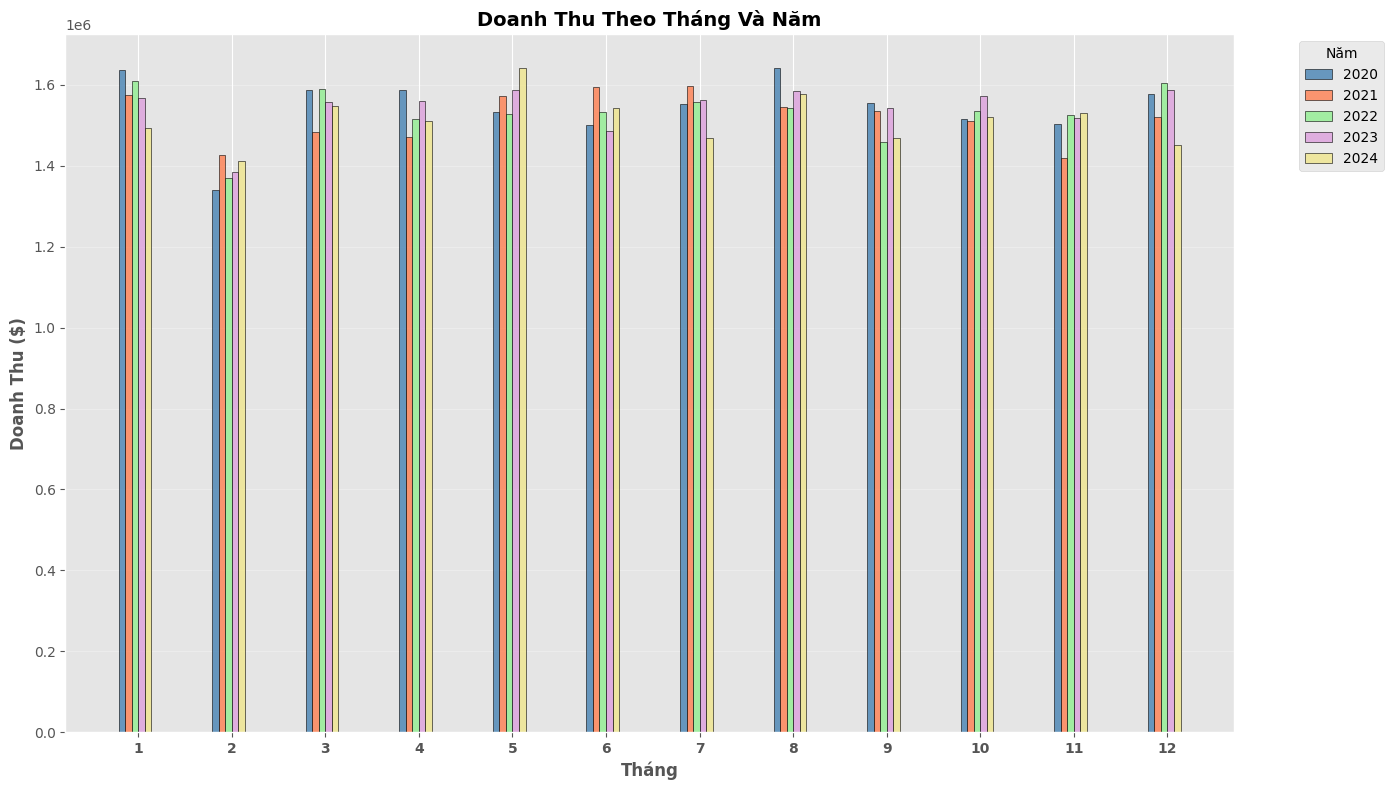

In [30]:
revenue_by_month_year = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
revenue_pivot = revenue_by_month_year.pivot(index='Month', columns='Year', values='Revenue').fillna(0)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(revenue_pivot.index))
width = 0.35

years = revenue_pivot.columns.tolist()
colors = ['steelblue', 'coral', 'lightgreen', 'plum', 'khaki']
for i, year in enumerate(years):
    offset = (i - len(years)/2) * width / len(years)
    ax.bar(x + offset, revenue_pivot[year], width/len(years), 
           label=str(year), color=colors[i % len(colors)], alpha=0.8, edgecolor='black')

ax.set_xlabel('Tháng', fontweight='bold', fontsize=12)
ax.set_ylabel('Doanh Thu ($)', fontweight='bold', fontsize=12)
ax.set_title('Doanh Thu Theo Tháng Và Năm', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(revenue_pivot.index, fontweight='bold')
ax.legend(title='Năm', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Q12: Giảm giá có ảnh hưởng đến số lượng mua không?

Đánh giá ảnh hưởng của giảm giá đến số lượng mua.

**Nhận xét:**
- Scatter plot cho thấy mối quan hệ giữa discount và số lượng mua. Nếu có xu hướng tích cực (discount cao, quantity cao), discount có tác động tích cực đến việc tăng số lượng mua.
- Nếu không có mối quan hệ rõ ràng, điều này cho thấy khách hàng không chỉ mua dựa trên discount mà còn dựa trên các yếu tố khác (nhu cầu, chất lượng, brand).
- Phân tích này giúp xác định chiến lược discount tối ưu để cân bằng giữa việc tăng số lượng bán và giảm profit margin.

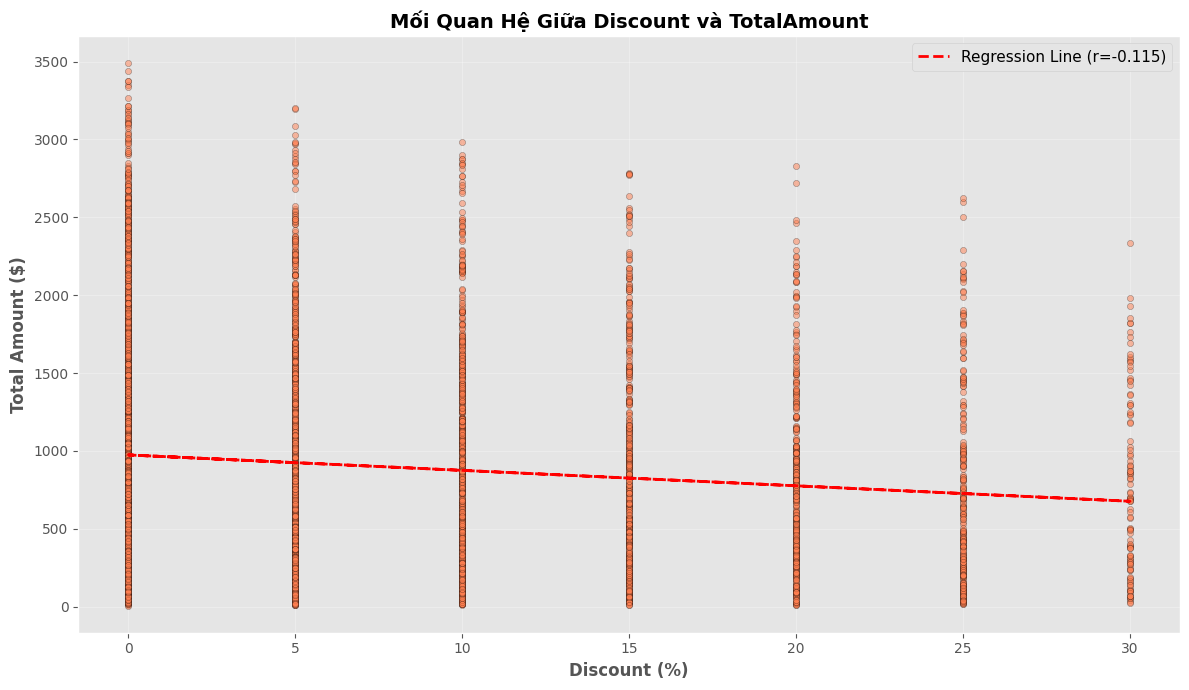

In [31]:
# Lấy sample để tránh quá nhiều điểm trên scatter plot
sample_size = min(5000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

fig, ax = plt.subplots(figsize=(12, 7))
scatter = ax.scatter(df_sample['Discount']*100, df_sample['TotalAmount'], 
                     alpha=0.5, s=20, color='coral', edgecolors='black', linewidth=0.3)

# Thêm regression line
from scipy import stats
x = df_sample['Discount']*100
y = df_sample['TotalAmount']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
ax.plot(x, line, 'r--', linewidth=2, label=f'Regression Line (r={r_value:.3f})')

ax.set_xlabel('Discount (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Total Amount ($)', fontweight='bold', fontsize=12)
ax.set_title('Mối Quan Hệ Giữa Discount và TotalAmount', fontweight='bold', fontsize=14)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Q14: Giá trị đơn hàng khác nhau như thế nào giữa các trạng thái?

So sánh giá trị đơn hàng giữa các trạng thái khác nhau.

**Nhận xét:**
- So sánh giá trị đơn hàng giữa các trạng thái cho thấy sự khác biệt về giá trị. Đơn hàng "Delivered" thường có giá trị cao hơn, phản ánh chất lượng dịch vụ tốt.
- Đơn hàng bị hủy hoặc trả lại có thể có giá trị thấp hơn hoặc cao hơn tùy thuộc vào lý do (sản phẩm không đúng, giá quá cao, v.v.).
- Phân tích này giúp xác định các vấn đề trong quy trình xử lý đơn hàng và cải thiện chất lượng dịch vụ để giảm tỷ lệ hủy/trả lại.

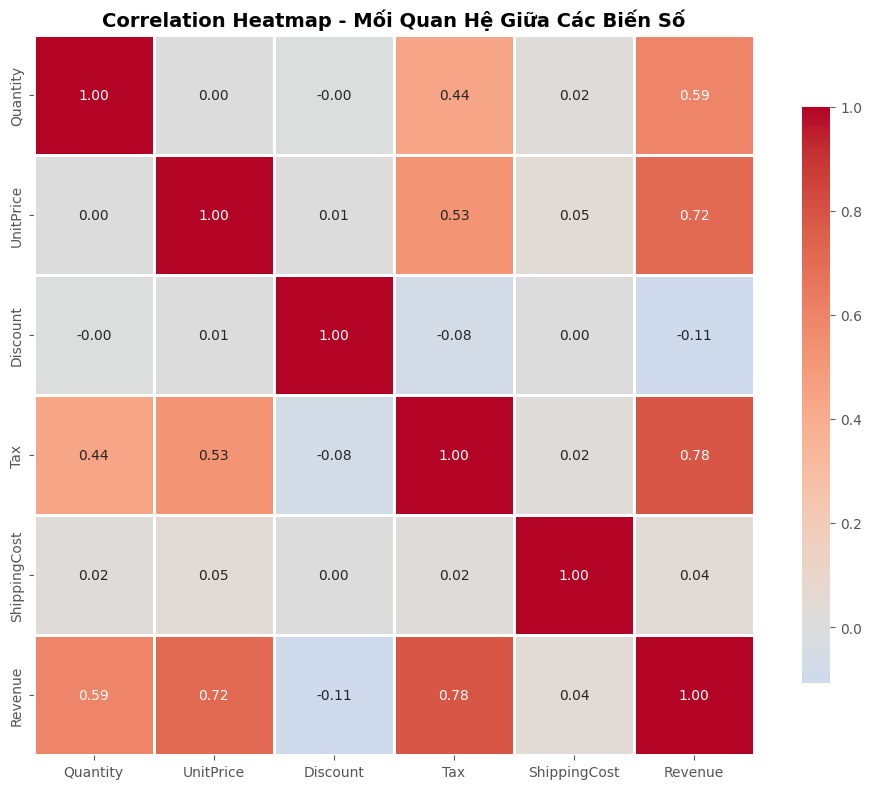

In [32]:
numeric_cols = ['Quantity', 'UnitPrice', 'Discount', 'Tax', 'ShippingCost', 'Revenue']
correlation_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            xticklabels=numeric_cols, yticklabels=numeric_cols)
ax.set_title('Correlation Heatmap - Mối Quan Hệ Giữa Các Biến Số', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

### Q16: Bảng phân phối của tổng doanh thu:


**Nhận xét:**

-  Biểu đồ phân phối tổng doanh thu (TotalAmount) cho thấy dữ liệu không tuân theo phân phối chuẩn, có độ lệch phải rõ rệt (right-skewed), với đuôi kéo dài về phía các giá trị doanh thu lớn.

- Giá trị mean ($918.26) lớn hơn median ($714.32), cho thấy tồn tại một số đơn hàng có doanh thu rất cao làm kéo trung bình lên, trong khi phần lớn đơn hàng có doanh thu ở mức trung bình–thấp.

- Phần lớn đơn hàng tập trung trong khoảng doanh thu từ 0 đến 1,000 USD, trong khi các đơn có doanh thu trên 2,000 USD chiếm tỷ lệ nhỏ nhưng có ảnh hưởng đáng kể đến tổng doanh thu.

- Sự chênh lệch giữa mean và median cho thấy việc sử dụng median có thể phản ánh tốt hơn giá trị điển hình của đơn hàng, đặc biệt trong các phân tích so sánh hoặc mô hình dự đoán

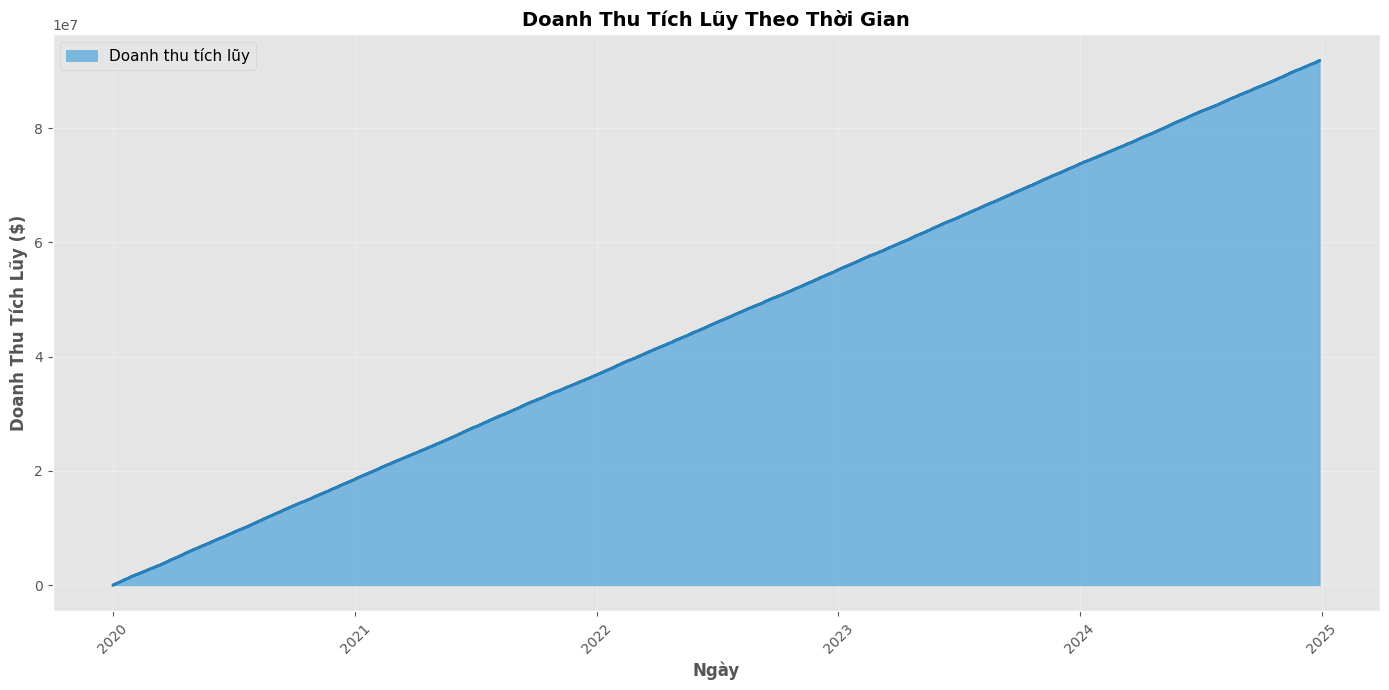

📊 Tổng doanh thu: $91,825,647.92
📈 Tăng trưởng trung bình mỗi tháng: $1,530,427.47


In [33]:
# Tính doanh thu tích lũy theo thời gian
df_sorted = df.sort_values('OrderDate')
df_sorted['CumulativeRevenue'] = df_sorted['Revenue'].cumsum()

fig, ax = plt.subplots(figsize=(14, 7))
ax.fill_between(df_sorted['OrderDate'], df_sorted['CumulativeRevenue'], 
                alpha=0.6, color='#3498db', label='Doanh thu tích lũy')
ax.plot(df_sorted['OrderDate'], df_sorted['CumulativeRevenue'], 
        color='#2980b9', linewidth=2)

ax.set_title('Doanh Thu Tích Lũy Theo Thời Gian', fontweight='bold', fontsize=14)
ax.set_xlabel('Ngày', fontweight='bold', fontsize=12)
ax.set_ylabel('Doanh Thu Tích Lũy ($)', fontweight='bold', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# In thống kê tăng trưởng
print(f"📊 Tổng doanh thu: ${df_sorted['CumulativeRevenue'].iloc[-1]:,.2f}")
print(f"📈 Tăng trưởng trung bình mỗi tháng: ${(df_sorted['CumulativeRevenue'].iloc[-1] / len(df_sorted['OrderDate'].dt.to_period('M').unique())):,.2f}")

### Q17: Phân khúc thị trường theo danh mục sản phẩm được phân chia như thế nào?

Phân tích thị phần của từng danh mục để hiểu cấu trúc doanh thu và xác định các danh mục chiếm ưu thế.

**Nhận xét:**
- Biểu đồ tròn cho thấy phân bổ thị phần rõ ràng, giúp xác định các danh mục chủ đạo và các danh mục cần phát triển.
- Danh mục có thị phần cao thường là những sản phẩm có nhu cầu lớn hoặc giá trị cao, đóng vai trò quan trọng trong chiến lược kinh doanh.
- Phân tích này hỗ trợ quyết định về việc đầu tư marketing, mở rộng sản phẩm, hoặc đa dạng hóa danh mục để cân bằng rủi ro.

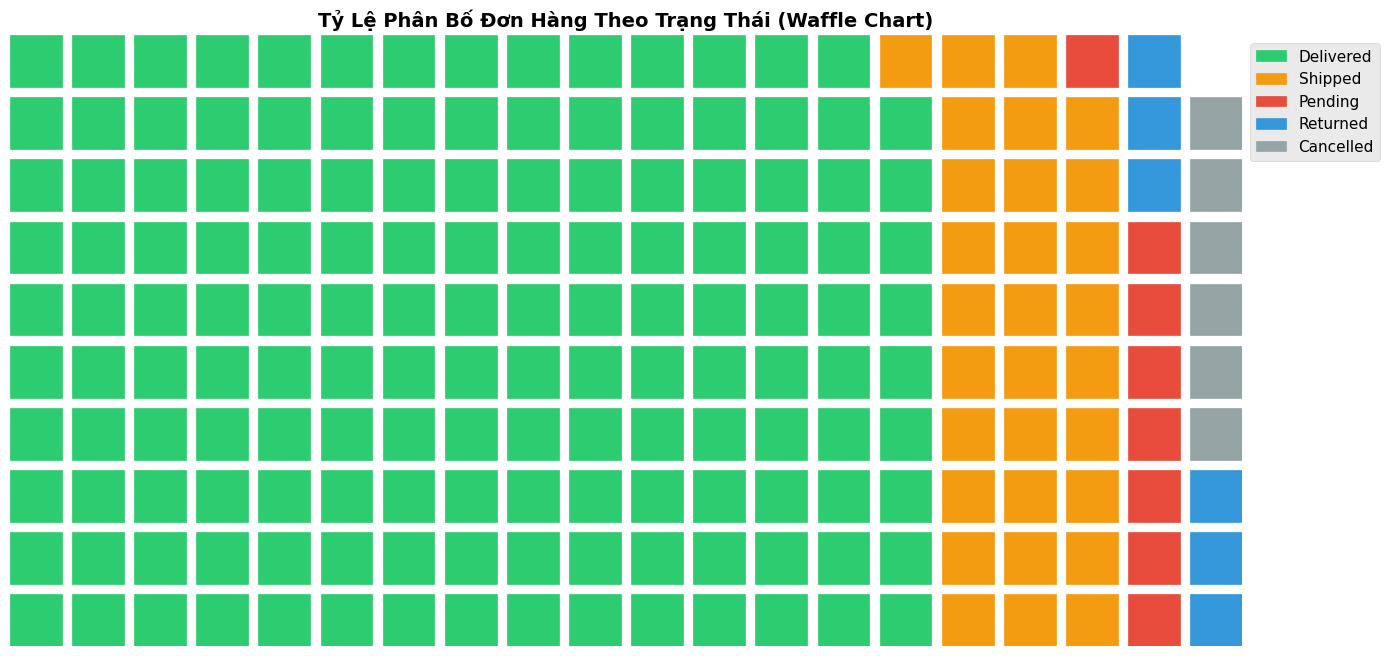

📊 Tỷ lệ phân bố:
  Delivered: 74.6%
  Shipped: 15.2%
  Pending: 4.1%
  Returned: 3.0%
  Cancelled: 3.0%


In [34]:
status_counts = df['OrderStatus'].value_counts()
status_pct = (status_counts / status_counts.sum() * 100).round(1)

# Tạo waffle chart
fig = plt.figure(FigureClass=Waffle, 
                 rows=10, 
                 columns=20,
                 values=status_pct.to_dict(),
                 colors=['#2ecc71', '#f39c12', '#e74c3c', '#3498db', '#95a5a6'][:len(status_pct)],
                 title={'label': 'Tỷ Lệ Phân Bố Đơn Hàng Theo Trạng Thái (Waffle Chart)', 
                        'loc': 'center', 'fontsize': 14, 'fontweight': 'bold'},
                 legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 11},
                 figsize=(14, 8))
plt.tight_layout()
plt.show()

print("📊 Tỷ lệ phân bố:")
for status, pct in status_pct.items():
    print(f"  {status}: {pct:.1f}%")

### Q19: Tên sản phẩm và thương hiệu nào xuất hiện nhiều nhất trong đơn hàng?

Phân tích từ khóa phổ biến từ tên sản phẩm và thương hiệu bằng word cloud để xác định xu hướng và sở thích khách hàng.

**Nhận xét:**
- Word cloud giúp nhận diện nhanh các từ khóa, tên sản phẩm và thương hiệu xuất hiện nhiều nhất, phản ánh xu hướng thị trường.
- Các từ khóa có kích thước lớn cho thấy mức độ phổ biến cao, có thể là điểm mạnh của doanh nghiệp hoặc cơ hội để tối ưu hóa.
- Phân tích này hỗ trợ chiến lược marketing, định vị sản phẩm, và xác định các thương hiệu đối tác tiềm năng.

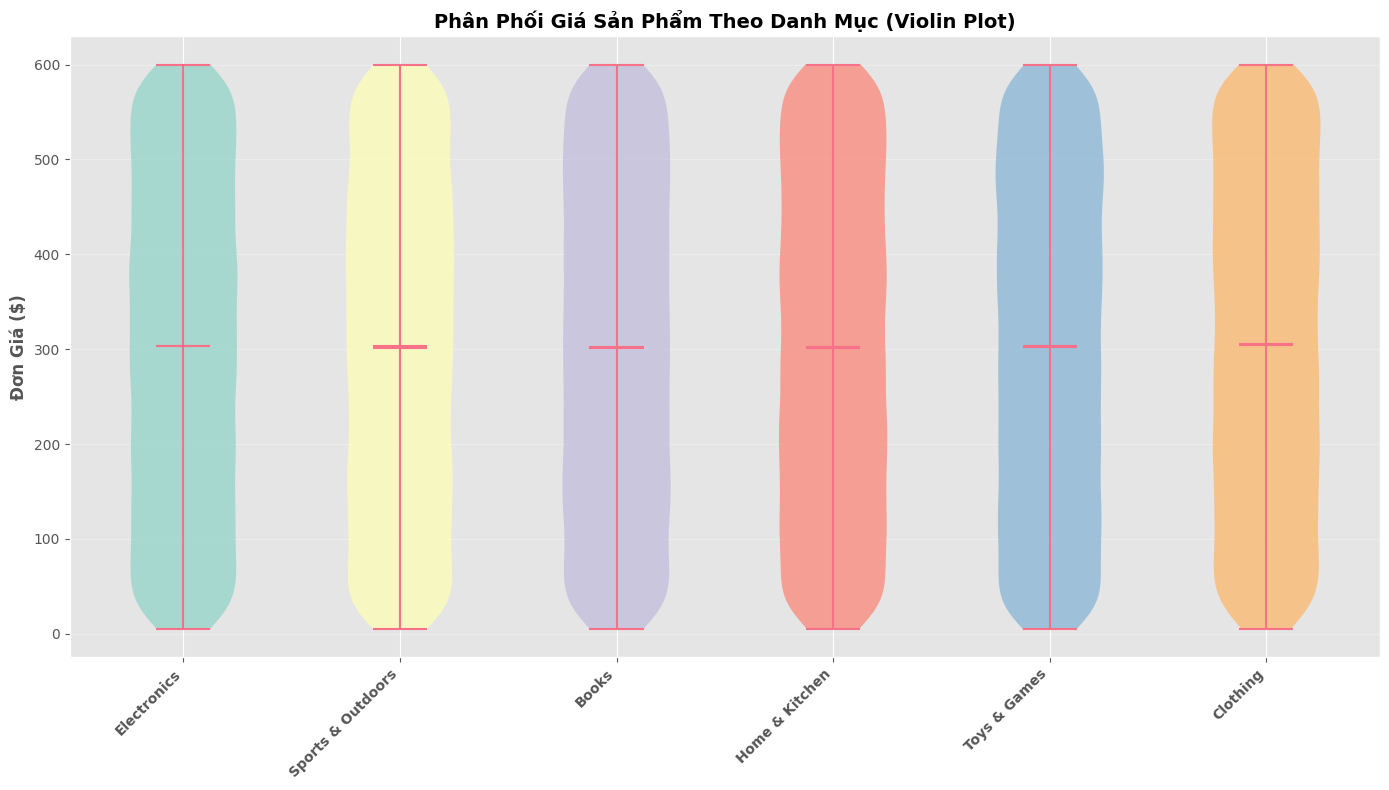

📊 Giá trung bình theo danh mục:
  Electronics: Trung bình $302.93, Median $303.48
  Sports & Outdoors: Trung bình $301.76, Median $303.08
  Books: Trung bình $302.02, Median $301.39
  Home & Kitchen: Trung bình $302.76, Median $301.19
  Toys & Games: Trung bình $302.81, Median $303.70


In [35]:
top_categories = df['Category'].value_counts().head(8).index
df_top_cat = df[df['Category'].isin(top_categories)]

fig, ax = plt.subplots(figsize=(14, 8))
violin_parts = ax.violinplot([df_top_cat[df_top_cat['Category']==cat]['UnitPrice'].values 
                               for cat in top_categories],
                             positions=range(len(top_categories)), 
                             showmeans=True, showmedians=True)

# Tùy chỉnh màu sắc
colors_violin = plt.cm.Set3(range(len(top_categories)))
for pc, color in zip(violin_parts['bodies'], colors_violin):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks(range(len(top_categories)))
ax.set_xticklabels(top_categories, rotation=45, ha='right', fontweight='bold', fontsize=10)
ax.set_ylabel('Đơn Giá ($)', fontweight='bold', fontsize=12)
ax.set_title('Phân Phối Giá Sản Phẩm Theo Danh Mục (Violin Plot)', 
             fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Thống kê giá trung bình
print("📊 Giá trung bình theo danh mục:")
for cat in top_categories[:5]:
    avg_price = df_top_cat[df_top_cat['Category']==cat]['UnitPrice'].mean()
    median_price = df_top_cat[df_top_cat['Category']==cat]['UnitPrice'].median()
    print(f"  {cat}: Trung bình ${avg_price:.2f}, Median ${median_price:.2f}")

### Q21: Xu hướng doanh thu theo từng danh mục thay đổi như thế nào theo thời gian?

Phân tích stacked area chart để xem sự đóng góp của từng danh mục vào tổng doanh thu theo thời gian.

**Nhận xét:**
- Stacked area chart cho thấy cả tổng doanh thu và đóng góp của từng danh mục, giúp nhận diện xu hướng theo thời gian.
- Danh mục có diện tích lớn đóng góp nhiều vào tổng doanh thu, trong khi các danh mục có diện tích nhỏ có thể cần chiến lược phát triển.
- Phân tích theo thời gian giúp phát hiện tính mùa vụ, xu hướng tăng/giảm của từng danh mục, và các điểm bất thường cần điều tra.

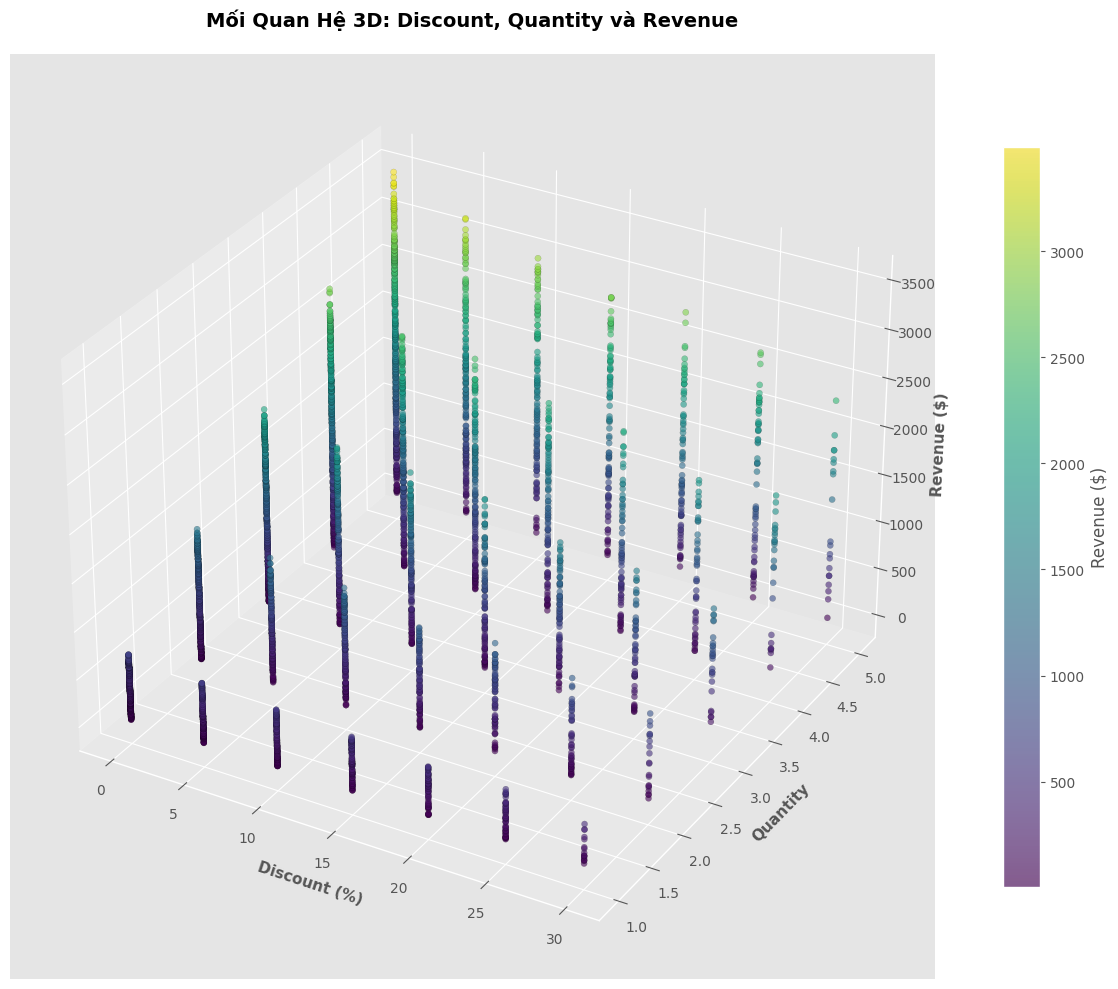

📊 Correlation matrix:
          Discount  Quantity  Revenue
Discount      1.00      0.01    -0.12
Quantity      0.01      1.00     0.59
Revenue      -0.12      0.59     1.00


In [36]:
# Lấy mẫu ngẫu nhiên để tránh quá tải
df_sample = df.sample(n=min(5000, len(df)), random_state=42)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_sample['Discount']*100, df_sample['Quantity'], 
                    df_sample['Revenue'], 
                    c=df_sample['Revenue'], cmap='viridis', 
                    alpha=0.6, s=20, edgecolors='black', linewidth=0.1)

ax.set_xlabel('Discount (%)', fontweight='bold', fontsize=11)
ax.set_ylabel('Quantity', fontweight='bold', fontsize=11)
ax.set_zlabel('Revenue ($)', fontweight='bold', fontsize=11)
ax.set_title('Mối Quan Hệ 3D: Discount, Quantity và Revenue', 
             fontweight='bold', fontsize=14, pad=20)

plt.colorbar(scatter, ax=ax, label='Revenue ($)', shrink=0.8)
plt.tight_layout()
plt.show()

# Tính correlation matrix
corr_vars = df_sample[['Discount', 'Quantity', 'Revenue']].corr()
print("📊 Correlation matrix:")
print(corr_vars.round(3))

### Q23: Làm thế nào để so sánh hiệu suất đa chiều của các danh mục sản phẩm?

Sử dụng radar chart để so sánh đồng thời nhiều chỉ số (revenue, quantity, average price, order count) của các danh mục.

**Nhận xét:**
- Radar chart cho phép so sánh đồng thời nhiều chỉ số, giúp đánh giá toàn diện hiệu suất của từng danh mục.
- Danh mục có diện tích lớn trên radar chart thường có hiệu suất tốt trên nhiều mặt, trong khi danh mục có hình dạng không đều cho thấy điểm mạnh/yếu riêng biệt.
- Phân tích này hỗ trợ xác định danh mục cần đầu tư phát triển, danh mục cần cải thiện, và các chỉ số cụ thể cần tập trung để tối ưu hóa hiệu suất.

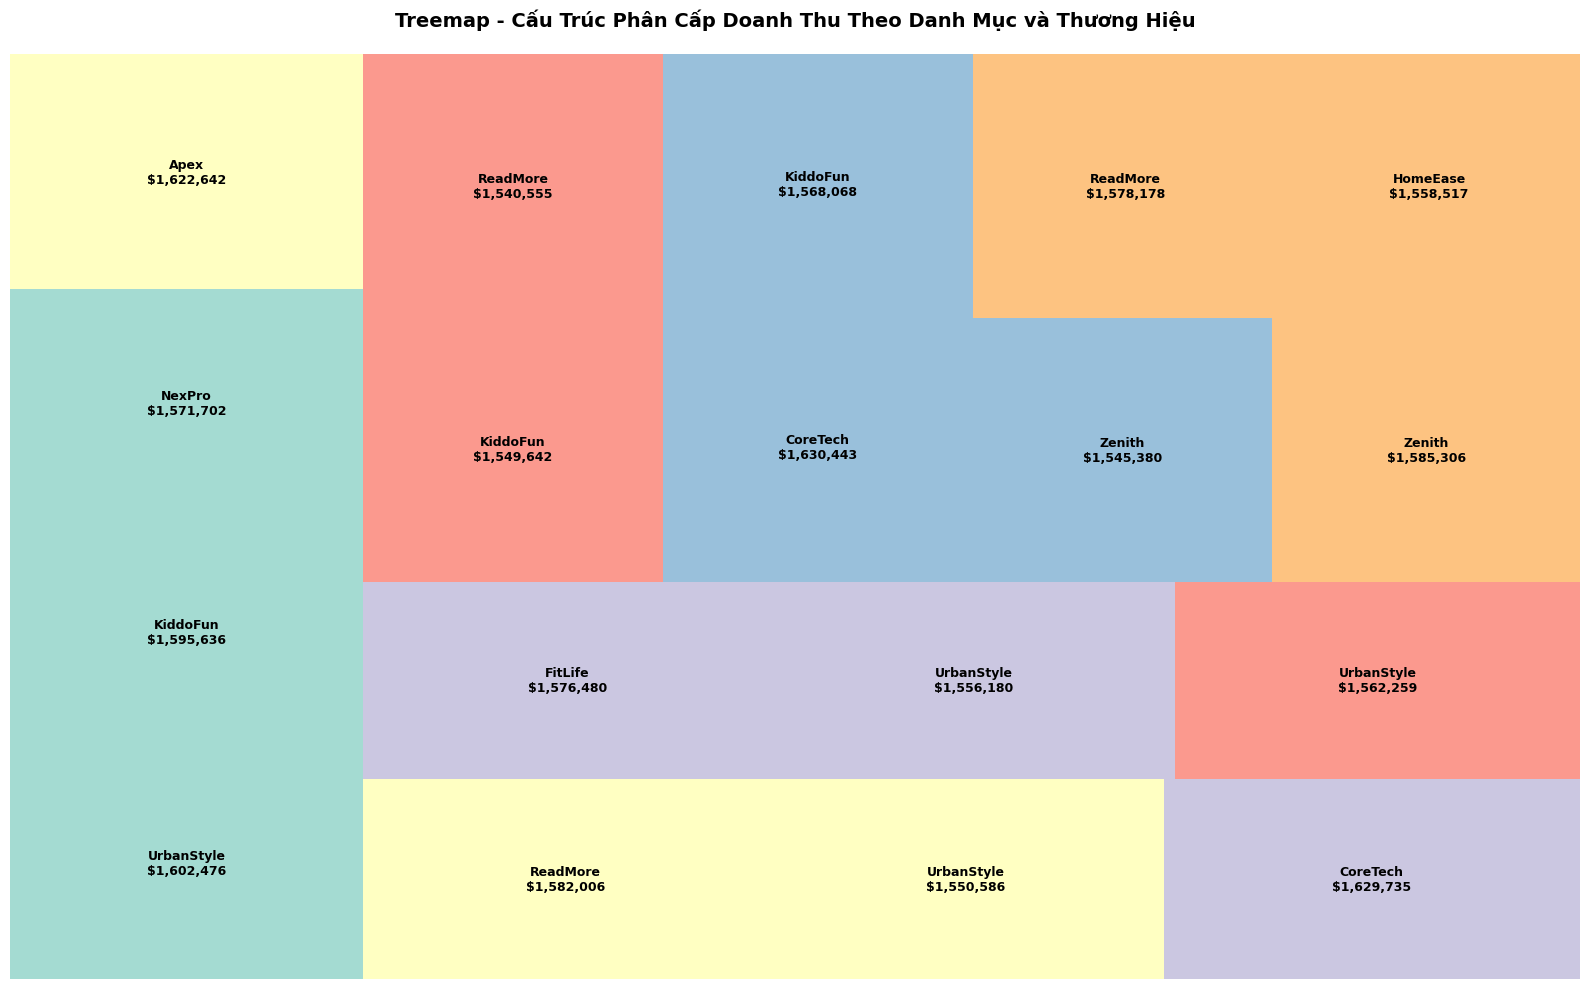

Top 5 cặp Category-Brand có doanh thu cao nhất:
  1. Toys & Games - CoreTech: $1,630,442.98
  2. Books - CoreTech: $1,629,735.16
  3. Sports & Outdoors - Apex: $1,622,641.60
  4. Electronics - UrbanStyle: $1,602,475.96
  5. Electronics - KiddoFun: $1,595,636.15


In [37]:
# Tính doanh thu theo danh mục và thương hiệu
category_brand_revenue = df.groupby(['Category', 'Brand'])['Revenue'].sum().reset_index()
category_brand_revenue = category_brand_revenue.sort_values('Revenue', ascending=False)

# Chọn top categories và brands
top_categories = category_brand_revenue.groupby('Category')['Revenue'].sum().nlargest(8).index
top_brands_per_cat = category_brand_revenue[category_brand_revenue['Category'].isin(top_categories)].groupby('Category').head(3)

# Tạo treemap
fig, ax = plt.subplots(figsize=(16, 10))

# Tạo labels và sizes
labels = []
sizes = []
colors_treemap = []
colors_list = plt.cm.Set3(range(len(top_categories)))

for idx, cat in enumerate(top_categories):
    cat_data = top_brands_per_cat[top_brands_per_cat['Category']==cat]
    for _, row in cat_data.iterrows():
        labels.append(f"{row['Brand']}\n${row['Revenue']:,.0f}")
        sizes.append(row['Revenue'])
        colors_treemap.append(colors_list[idx])

squarify.plot(sizes=sizes, label=labels, alpha=0.8, 
              color=colors_treemap, text_kwargs={'fontsize': 9, 'fontweight': 'bold'})

ax.set_title('Treemap - Cấu Trúc Phân Cấp Doanh Thu Theo Danh Mục và Thương Hiệu', 
             fontweight='bold', fontsize=14, pad=20)
ax.axis('off')
plt.tight_layout()
plt.show()

print("Top 5 cặp Category-Brand có doanh thu cao nhất:")
for i, (_, row) in enumerate(category_brand_revenue.head(5).iterrows(), 1):
    print(f"  {i}. {row['Category']} - {row['Brand']}: ${row['Revenue']:,.2f}")

### Q25: Doanh thu phân bố như thế nào giữa các quốc gia trên thế giới?

Sử dụng Choropleth Map để hiển thị phân bố doanh thu theo quốc gia, giúp xác định các thị trường quan trọng và tiềm năng phát triển. Liệu doanh thu có bị ảnh hưởn bới khu vực tức là ở các thành phố lớn hay ở các nước phát triển sẽ có trọng số trong doanh thu lớn hơn không

In [38]:

countries = df['Country'].unique()
states = df['State'].unique()

print(f"📍 Số lượng quốc gia: {len(countries)}")
print(f"Các quốc gia: {', '.join(sorted(countries))}")
print(f"\n📍 Số lượng bang/tiểu bang: {len(states)}")
print(f"Các bang/tiểu bang: {', '.join(sorted(states))}")

# Thống kê số lượng đơn hàng và doanh thu theo quốc gia
country_stats = df.groupby('Country').agg({
    'OrderID': 'count',
    'Revenue': 'sum'
}).rename(columns={'OrderID': 'Orders'})
country_stats['Revenue'] = country_stats['Revenue'].round(2)
country_stats = country_stats.sort_values('Revenue', ascending=False)

print("\n📊 Thống kê theo quốc gia:")
print(country_stats)

📍 Số lượng quốc gia: 5
Các quốc gia: Australia, Canada, India, United Kingdom, United States

📍 Số lượng bang/tiểu bang: 13
Các bang/tiểu bang: AZ, CA, CO, DC, FL, IL, IN, NC, NY, OH, PA, TX, WA

📊 Thống kê theo quốc gia:
                Orders     Revenue
Country                           
United States    70058 64310048.50
India            15051 13875839.12
Canada            5818  5323757.00
United Kingdom    4943  4526896.86
Australia         4130  3789106.44


### Q26: Liệu shipping cost có ảnh hưởng đến trạng thái đơn hàng không?

Trung bình ShippingCost theo OrderStatus:
OrderStatus
Cancelled   7.40
Delivered   7.40
Pending     7.41
Returned    7.43
Shipped     7.41
Name: ShippingCost, dtype: float64
So sánh số lượng đơn hàng theo ShipGroup và OrderStatus:
OrderStatus  Cancelled  Delivered  Pending  Returned  Shipped
ShipGroup                                                    
Low                770      18629     1047       745     3841
Medium             749      18833      981       750     3700
High               735      18574     1057       813     3832
Very High          774      18592     1018       741     3819


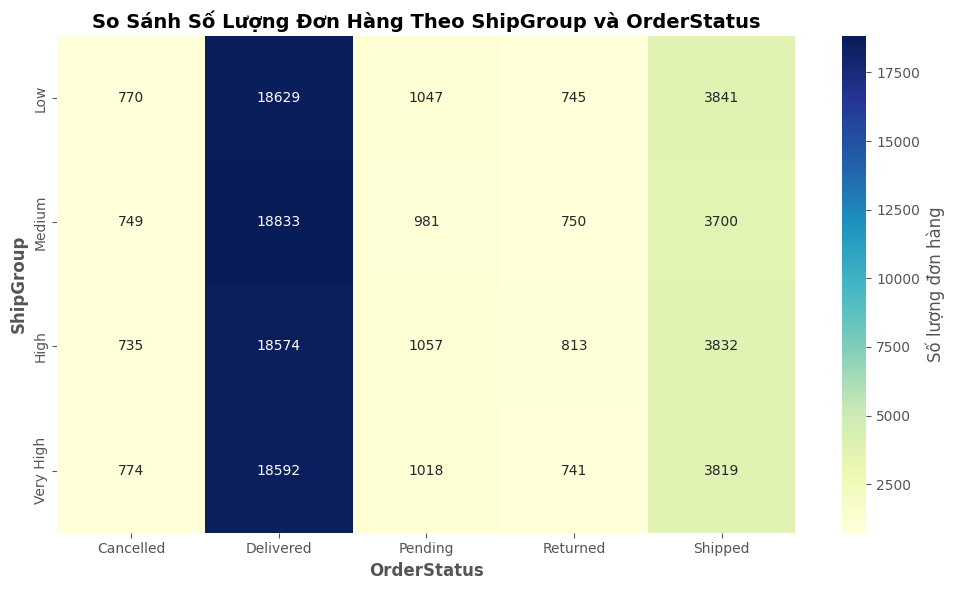

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1) Trung bình ShippingCost theo OrderStatus
shipping_cost_mean = df.groupby("OrderStatus")["ShippingCost"].mean()
print("Trung bình ShippingCost theo OrderStatus:")
print(shipping_cost_mean)

# 2) Tạo nhóm ShipGroup (an toàn với missing / ít unique values)
shipping = df["ShippingCost"]

# Nếu có missing, giữ nguyên nhưng báo cáo
if shipping.isnull().any():
    print(f"Cảnh báo: {shipping.isnull().sum()} giá trị ShippingCost bị thiếu.")

labels = ["Low", "Medium", "High", "Very High"]
try:
    # Thử qcut trước (chia theo phân vị)
    df["ShipGroup"] = pd.qcut(shipping, q=4, labels=labels)
except Exception:
    # Nếu qcut lỗi (ví dụ quá ít giá trị khác nhau), dùng cut theo bins đều
    df["ShipGroup"] = pd.cut(shipping, bins=4, labels=labels)

# Nếu vẫn có NaN do giá trị thiếu, thêm category 'Unknown' và điền
if df["ShipGroup"].isnull().any():
    df["ShipGroup"] = df["ShipGroup"].astype("category")
    if "Unknown" not in df["ShipGroup"].cat.categories:
        df["ShipGroup"] = df["ShipGroup"].cat.add_categories(["Unknown"])
    df["ShipGroup"] = df["ShipGroup"].fillna("Unknown")

# Đảm bảo thứ tự hợp lý cho hiển thị
ordered_cats = ["Low", "Medium", "High", "Very High", "Unknown"]
df["ShipGroup"] = pd.Categorical(
    df["ShipGroup"],
    categories=[c for c in ordered_cats if c in df["ShipGroup"].cat.categories],
    ordered=True,
)

# 3) Bảng so sánh và in ra
shipgroup_orderstatus = (
    df.groupby(["ShipGroup", "OrderStatus"]).size().unstack(fill_value=0)
)
print("So sánh số lượng đơn hàng theo ShipGroup và OrderStatus:")
print(shipgroup_orderstatus)

# 4) Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    shipgroup_orderstatus,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar_kws={"label": "Số lượng đơn hàng"},
)
plt.title(
    "So Sánh Số Lượng Đơn Hàng Theo ShipGroup và OrderStatus",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("OrderStatus", fontsize=12, fontweight="bold")
plt.ylabel("ShipGroup", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

**Nhận xét:**
- Kết quả cho thấy chi phí vận chuyển trung bình (ShippingCost) giữa các trạng thái đơn hàng gần như không có sự khác biệt đáng kể, với giá trị dao động rất nhỏ quanh mức 7.40 – 7.43 USD cho tất cả các trạng thái Cancelled, Delivered, Pending, Returned và Shipped. Điều này cho thấy chi phí vận chuyển trung bình không phải là yếu tố phân biệt rõ ràng giữa các trạng thái đơn hàng.

- Biểu đồ heatmap so sánh số lượng đơn hàng theo ShipGroup và OrderStatus cho thấy phần lớn đơn hàng ở tất cả các nhóm chi phí vận chuyển đều có trạng thái Delivered, chiếm tỷ trọng áp đảo so với các trạng thái còn lại.

- Số lượng đơn hàng bị Cancelled và Returned tương đối đồng đều giữa các nhóm chi phí vận chuyển, không có xu hướng tăng rõ rệt ở nhóm High hoặc Very High. Điều này cho thấy chi phí vận chuyển cao không làm gia tăng đáng kể tỷ lệ huỷ hoặc trả đơn trong bộ dữ liệu này.

- Trạng thái Shipped cũng phân bố khá tương đồng giữa các ShipGroup, cho thấy tiến trình xử lý đơn hàng không bị ảnh hưởng nhiều bởi mức phí vận chuyển.

- Tổng hợp các kết quả trên cho thấy ShippingCost không phải là yếu tố chính ảnh hưởng đến trạng thái đơn hàng.

## Q27: Tỉ lệ doanh thu giữa nhóm khách chi mua một lần và nhóm khách hàng quay trở lại 

Số lượng khách hàng theo loại:
Customer_type
Khách mua nhiều lần    57956
Khách mua 1 lần        16672
Name: count, dtype: int64
Phân tích doanh thu theo loại khách hàng:
                        Revenue  Share (%)
Customer_type                             
Khách mua 1 lần     15261556.99      22.32
Khách mua nhiều lần 53111120.11      77.68


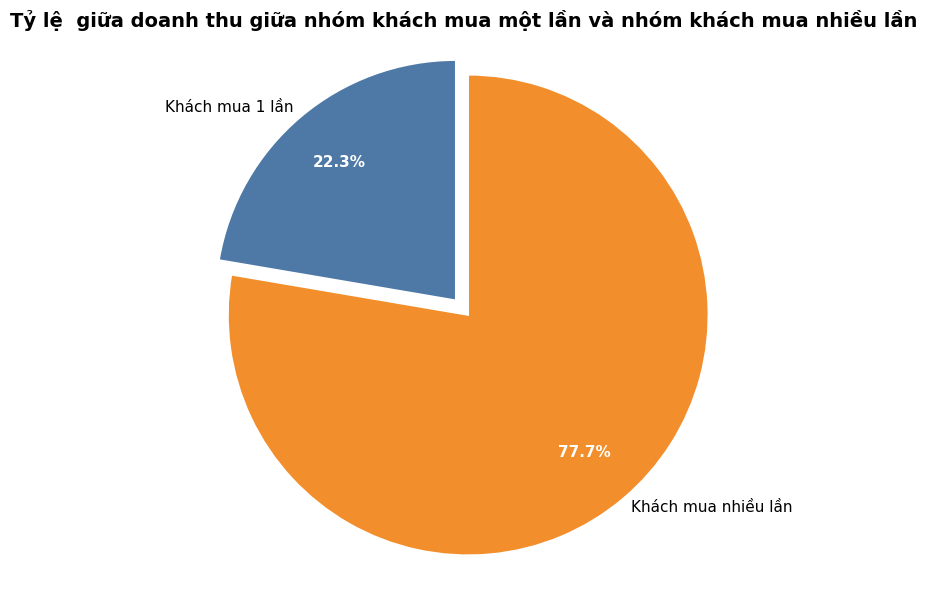

In [40]:
# Phân tích doanh thu và tỷ lệ doanh thu của khách hàng theo loại
import pandas as pd
import matplotlib.pyplot as plt

# Lấy số đơn đã giao theo khách hàng
orders_per_customer = df[df['OrderStatus'] == 'Delivered'].groupby('CustomerID')['OrderID'].nunique()

def categorize_customer(n: int) -> str:
    return 'Khách mua 1 lần' if n == 1 else 'Khách mua nhiều lần'

customer_type = orders_per_customer.map(categorize_customer)

# Gán nhãn phân khúc cho cả df và df_deli (tránh KeyError)
df['Customer_type'] = df['CustomerID'].map(customer_type)

# Tạo df_deli sau khi gán nhãn để đảm bảo có cột Customer_type
df_deli = df[df['OrderStatus'] == 'Delivered'].copy()

# Đếm số lượng khách hàng theo loại
customer_type_counts = df_deli['Customer_type'].value_counts()
print("Số lượng khách hàng theo loại:")
print(customer_type_counts)

# Tính doanh thu và tỷ lệ doanh thu theo loại khách hàng
customer_revenue = df_deli.groupby('Customer_type')['TotalAmount'].sum()
share = (customer_revenue / customer_revenue.sum() * 100).round(2)

customer_analysis = pd.DataFrame({'Revenue': customer_revenue.round(2), 'Share (%)': share})
print("Phân tích doanh thu theo loại khách hàng:")
print(customer_analysis)

fig, ax = plt.subplots(figsize=(7, 6))

labels = share.index.tolist()
sizes = share.values  
colors = ["#4E79A7", "#F28E2B"]
explode = [0.02, 0.06]


pie_res = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    explode=explode,
    autopct="%1.1f%%",
    pctdistance=0.75,
    labeldistance=1.05,
    wedgeprops={"edgecolor": "white", "linewidth": 1.2},
    textprops={"fontsize": 11},
)

if len(pie_res) == 3:
    wedges, texts, autotexts = pie_res
else:
    wedges, texts = pie_res
    autotexts = []

# Làm chữ % đậm hơn cho dễ nhìn (nếu có autotexts)
for t in autotexts:
    t.set_fontweight("bold")
    t.set_color("white")

ax.set_title(
    "Tỷ lệ  giữa doanh thu giữa nhóm khách mua một lần và nhóm khách mua nhiều lần", fontsize=14, fontweight="bold"
)
ax.axis("equal")
plt.tight_layout()
plt.show()

### Nhận xét:

* Biểu đồ cho thấy doanh thu **không phân bổ đồng đều** giữa hai nhóm khách hàng. Nhóm **khách mua nhiều lần** đóng góp **phần lớn doanh thu**, đạt khoảng **77.7%**, trong khi nhóm **khách mua 1 lần** chỉ chiếm khoảng **22.3%** tổng doanh thu.
* Kết quả này phản ánh rằng **khách hàng mua lặp lại (repeat customers)** là nhóm mang lại **giá trị kinh tế cao hơn** và có vai trò quan trọng trong việc duy trì doanh thu bền vững cho doanh nghiệp.
* Mặc dù khách mua 1 lần vẫn tạo ra một phần doanh thu đáng kể, tỷ trọng thấp hơn cho thấy tiềm năng cải thiện bằng cách **chuyển đổi nhóm khách mua 1 lần thành khách hàng trung thành** thông qua các chiến lược như chương trình thành viên, ưu đãi cho lần mua tiếp theo hoặc cá nhân hóa đề xuất sản phẩm.
* Từ góc độ kinh doanh, insight này gợi ý doanh nghiệp nên ưu tiên **chiến lược retention/loyalty** nhằm tăng tần suất mua lại, vì chỉ cần tăng tỷ lệ khách quay lại cũng có thể tạo tác động lớn đến tổng doanh thu.


## Q28:  Liệu các tổ hợp payment method, discount và total amount có ảnh hưởng đến khả năng hoàn thành của đơn hàng hay không?

Tỷ lệ NotDelivered toàn bộ: 6.08%


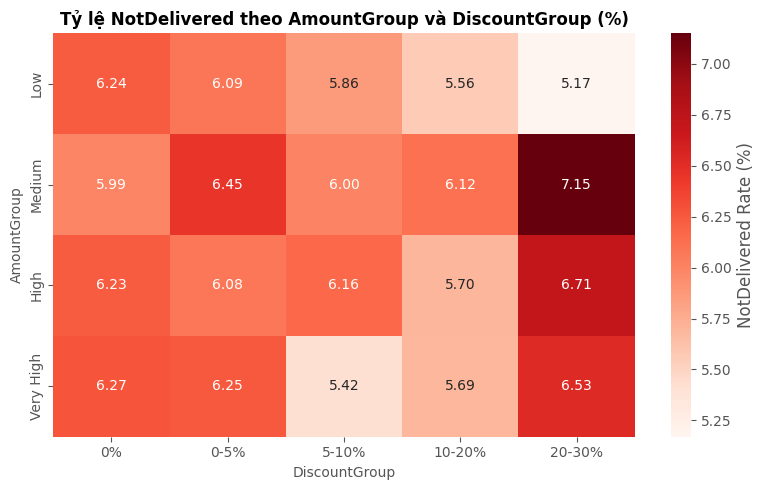

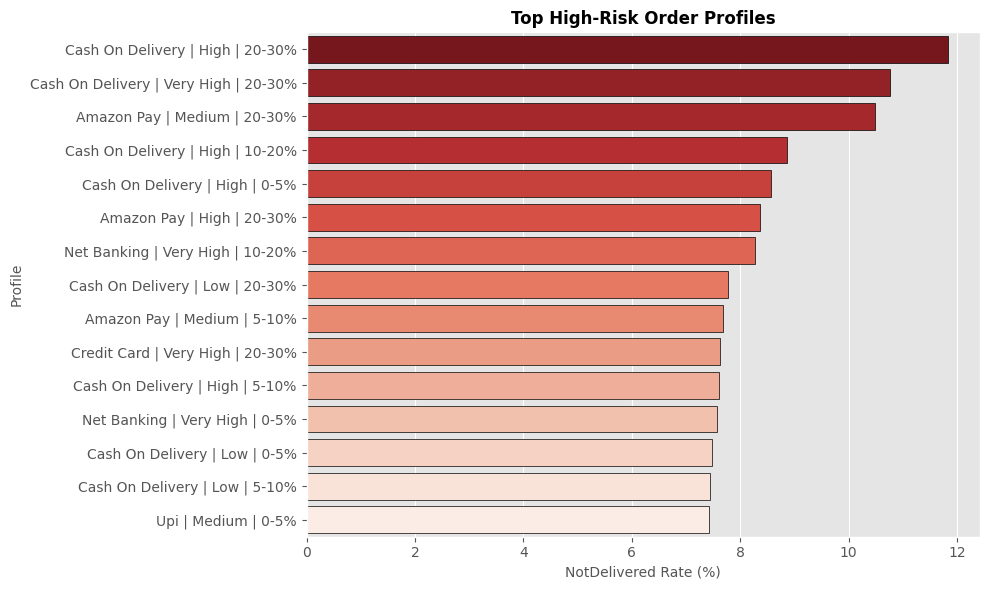

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Đánh dấu đơn hàng NotDelivered (Cancelled hoặc Returned)
df["NotDelivered"] = df["OrderStatus"].isin(["Cancelled", "Returned"]).astype(int)

# 2. Chia nhóm TotalAmount theo quartile
df["AmountGroup"] = pd.qcut(
    df["TotalAmount"], 4, labels=["Low", "Medium", "High", "Very High"]
)

# 3. Chia nhóm Discount theo ngưỡng
discount_bins = [-0.001, 0, 0.05, 0.10, 0.20, 0.30]
discount_labels = ["0%", "0-5%", "5-10%", "10-20%", "20-30%"]
df["DiscountGroup"] = pd.cut(
    df["Discount"], bins=discount_bins, labels=discount_labels, include_lowest=True
)

# 4. Tính profile theo AmountGroup, DiscountGroup, và PaymentMethod
profile = (
    df.groupby(["AmountGroup", "DiscountGroup", "PaymentMethod"], observed=True)
    .agg(
        Orders=("OrderID", "count"),
        NotDeliveredRate=("NotDelivered", "mean"),
        AvgAmount=("TotalAmount", "mean"),
    )
    .reset_index()
)

# Làm tròn các giá trị
profile["NotDeliveredRate%"] = (profile["NotDeliveredRate"] * 100).round(2)
profile["AvgAmount"] = profile["AvgAmount"].round(2)

# 5. Tỷ lệ NotDelivered toàn bộ
global_notdel_rate = df["NotDelivered"].mean() * 100
print(f"Tỷ lệ NotDelivered toàn bộ: {global_notdel_rate:.2f}%")

# 6. Heatmap: Tỷ lệ NotDelivered theo AmountGroup và DiscountGroup
risk_matrix = (
    df.groupby(["AmountGroup", "DiscountGroup"], observed=True)["NotDelivered"]
    .mean()
    .unstack()
    * 100
)

plt.figure(figsize=(8, 5))
sns.heatmap(
    risk_matrix.round(2),
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={"label": "NotDelivered Rate (%)"},
)
plt.title(
    "Tỷ lệ NotDelivered theo AmountGroup và DiscountGroup (%)",
    fontsize=12,
    fontweight="bold",
)
plt.xlabel("DiscountGroup", fontsize=10)
plt.ylabel("AmountGroup", fontsize=10)
plt.tight_layout()
plt.show()

# 7. Top 15 tổ hợp rủi ro cao nhất
top_risky = profile.sort_values("NotDeliveredRate%", ascending=False).head(15)
top_risky["Profile"] = (
    top_risky["PaymentMethod"].astype(str)
    + " | "
    + top_risky["AmountGroup"].astype(str)
    + " | "
    + top_risky["DiscountGroup"].astype(str)
)

# 8. Barplot: Top high-risk order profiles
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_risky,
    y="Profile",
    x="NotDeliveredRate%",
    palette="Reds_r",
    edgecolor="black",
)
plt.xlabel("NotDelivered Rate (%)", fontsize=10)
plt.ylabel("Profile", fontsize=10)
plt.title("Top High-Risk Order Profiles", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

Heatmap – Tỷ lệ NotDelivered theo AmountGroup và DiscountGroup (%)
- Tỷ lệ NotDelivered toàn bộ dataset khoảng 6.08% – đây là mốc tham chiếu để so sánh.
- Các ô trong heatmap dao động quanh khoảng 5–7%, nhưng có vài “điểm nóng” rõ ràng:
- Nhóm đơn Medium với giảm giá 20–30% có tỷ lệ NotDelivered cao nhất (khoảng 7.15%).
- Nhóm đơn High với giảm giá 20–30% cũng nằm trong vùng rủi ro, khoảng 6.7%, cao hơn mặt bằng chung.
- Ngược lại, các đơn Low value với giảm giá 20–30% lại có tỷ lệ NotDelivered thấp nhất (khoảng 5.17%), thấp hơn đáng kể so với trung bình → giảm giá sâu ở đơn nhỏ khá an toàn.

Bar chart – Top High-Risk Order Profiles
- Biểu đồ thanh thể hiện top các tổ hợp PaymentMethod – AmountGroup – DiscountGroup có tỷ lệ NotDelivered cao nhất.
- Dễ thấy các profile rủi ro nhất đều có điểm chung:
- Cash On Delivery | High | 20–30% đứng đầu, với tỷ lệ NotDelivered xấp xỉ 12%, gần gấp đôi mức trung bình 6.08%.
- Cash On Delivery | Very High | 20–30% cũng có tỷ lệ NotDelivered rất cao (khoảng 11%+).
- Một số profile khác như Amazon Pay | Medium | 20–30%, Cash On Delivery | High | 10–20%, Amazon Pay | High | 20–30% cũng nằm trong nhóm rủi ro, với tỷ lệ NotDelivered đều cao hơn đáng kể so với trung bình.
- Trong khi đó, các tổ hợp Low/Medium amount với discount thấp hơn (0–5%, 5–10%) hoặc không giảm giá thường không xuất hiện trong top rủi ro, cho thấy chúng ổn định hơn nhiều.